# Hedging your Startup Equity
a case study with Uber and Lyft, prepared on 5.19.20. Questions/comments/concerns? Please email adrian@lechterventures.com!



*Some in clandestine companies combine;*

*Erect new stocks to trade beyond the line;*

*With air and empty names beguile the town,*

*And raise new credits first, then cry ‘em down;*

*Divide the empty nothing into shares,*

*And set the crowd together by the ears.*

-- Defoe


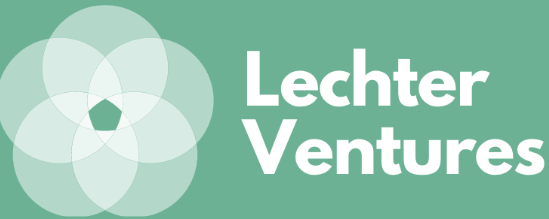

In [40]:
from IPython.display import display, Image
Image('Supplementary Files/Lechter Ventures Master.png')

----

**Disclaimer**

_The information summarised herein does not constitute financial or other professional advice and is general in nature. It does not take into account your specific circumstances and should not be acted on without full understanding of your current situation and future goals and objectives by a fully qualified financial advisor. In doing so you risk making commitments to a product and/or strategy that may not be suitable to your needs._

_Whilst I have tried to ensure the accuracy and completeness of the contents of this document, Lechter Ventures, LLC cannot offer any undertaking or guarantee, either expressly or implicitly, including liability towards third parties, regarding how correct, complete or up to date the contents of this document are. I reserve the right to supplement this document at any time or to change or delete any information contained or views expressed on this document._

_Lechter Ventures, LLC accepts no liability for any loss or damage howsoever arising out of the use of this document or reliance on the content of the document._

----

### TL;DR
If you own vested equity in a startup and want to protect its value in the case of a bankruptcy or other unforeseen circumstance, you can initiate a pair trade or sell covered calls.

### Context
Even before Coronavirus reached the United States, I have been frustrated at the challenges my generation has experienced in building wealth that are unique to our time. We have now lived through **TWO** "once-in-a-lifetime" economic catastrophes (2008 financial crisis and the one we're currently experiencing), a new-world-order-disrupting terrorist attack in 9/11; all while my generation gets saddled with unprecedented amounts of debt without some plan to pay it back (this can be represented in the ~\\$3T+ outstanding US student debt or the ~\\$25T outstanding US national debt).

In this environment, I have seen a countless amount of ambitious, well-intentioned individuals take jobs at various startups on the premise that they'd make a killing on their equity. I believe Tech in a millenial's adulthood has been one of the few pockets of consistent growth in our country, so I certainly empathize with this cohort (of which I am frankly a part).

Did a founder, recruiter or other employee convince you to join a startup? If so, has your vested equity performed worse than you expected? I believe I can help you.

### Goal
The goal of this research is to educate folks on how to hedge their vested equity. This can be done in numerous ways; here I'll focus on two of them (initiating a pair trade or selling covered calls).

With our goal clearly defined, let's begin ingesting the data and discussing our hedge opportunities, using Uber-Lyft as our primary example. For non-technical folks, feel free to skip straight to the **Results** section.

-----


### Import Libraries and Ingest Data

Here, we prepare our notebook for analysis and view the charts of Uber and Lyft seperately.

In [32]:
#Import libs
import ffn as f
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display, Image
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from datetime import timedelta, datetime
import pandas_datareader as pdr
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings

#to display visuals in notebook
%matplotlib inline
warnings.filterwarnings('ignore')
init_notebook_mode(connected = True)

#hack used to access yahoo finance data for pandas data manipulation
yf.pdr_override() 

In [33]:
#What do LYFT, UBER charts look like?

#Creating dictionary of dataframes for each asset
dataframes = {}
company_list = ['LYFT', 'UBER']

#Loop through the securities and build graphs for each
for name in company_list:
        dataframes['df_' + name] = pd.DataFrame()

        #looking at data since IPO
        dataframes['df_' + name] = pdr.get_data_yahoo(name, start = '2018-01-01', interval='d')
        fig = go.Figure(data=[go.Candlestick(x=dataframes['df_' + name].index,
                        open=dataframes['df_' + name]['Open'],
                        high=dataframes['df_' + name]['High'],
                        low=dataframes['df_' + name]['Low'],
                        close=dataframes['df_' + name]['Close'])], 
                        layout=go.Layout(title=go.layout.Title(text= name + " since IPO", 
                                                               x = 0.5,
                                                              font=dict(
                                                                    family="PT Sans Narrow",
                                                                    size=40,
                                                                    color="#7f7f7f",
                                                                    )
                                                              )
                                        )
                       )
        
        #add some labels to make the graphs look hot
        fig.update_layout(
            xaxis_title="Time",
            yaxis_title="Price",
            font=dict(
                family="Courier New",
                size=15,
                color="#7f7f7f"
            )
        )
        display(fig)

### Feature Engineering
Here, I make some tweaks to the data I ingested so we can more easily study whats going on here. 

In [34]:
#Looping through dataframes to rename columnns, remove the ones Im not using and then preview them
for name in company_list:
    dataframes['df_' + name] = \
        dataframes['df_' + name].rename(columns= {'High':'High_' + name, 
                                                  'Low':'Low_' + name, 'Open':'Open_' + name, 
                                                  'Close':'Close_' + name})
    dataframes['df_' + name] = \
        dataframes['df_' + name][['High_' + name, 'Low_' + name, 
                                  'Open_' + name, 'Close_' + name]]
    
    #Display previews of dataframes
    display(dataframes['df_' + name].head())

,High_LYFT,Low_LYFT,Open_LYFT,Close_LYFT
Date,,,,
2019-03-29,88.599998,78.019997,87.330002,78.290001
2019-04-01,75.000000,67.779999,74.900002,69.010002
2019-04-02,70.199997,66.099998,66.900002,68.970001
2019-04-03,72.000000,69.120003,70.059998,70.000000
2019-04-04,72.889999,70.220001,70.480003,72.000000


,High_UBER,Low_UBER,Open_UBER,Close_UBER
Date,,,,
2019-05-10,45.000000,41.060001,42.000000,41.570000
2019-05-13,39.240002,36.080002,38.790001,37.099998
2019-05-14,39.959999,36.849998,38.310001,39.959999
2019-05-15,41.880001,38.950001,39.369999,41.290001
2019-05-16,44.060001,41.250000,41.480000,43.000000


In [35]:
#Combine dataframes and preview them
df_uber_lyft_spread = dataframes['df_LYFT'].join(dataframes['df_UBER'])
df_uber_lyft_spread = df_uber_lyft_spread[(df_uber_lyft_spread.High_UBER.notnull())
                                           &
                                          (df_uber_lyft_spread.Low_UBER.notnull())]
df_uber_lyft_spread.head()

,High_LYFT,Low_LYFT,Open_LYFT,Close_LYFT,High_UBER,Low_UBER,Open_UBER,Close_UBER
Date,,,,,,,,
2019-05-10,56.490002,50.020000,56.389999,51.090000,45.000000,41.060001,42.000000,41.570000
2019-05-13,50.090000,47.169998,50.000000,48.150002,39.240002,36.080002,38.790001,37.099998
2019-05-14,51.389999,48.000000,48.820000,50.520000,39.959999,36.849998,38.310001,39.959999
2019-05-15,54.849998,49.860001,50.200001,54.040001,41.880001,38.950001,39.369999,41.290001
2019-05-16,56.720001,53.549999,54.099998,55.599998,44.060001,41.250000,41.480000,43.000000


In [36]:
#Looping through OHLC datapoints to calculate Uber-Lyft spread for each
columns = ['Open', 'High', 'Low', 'Close']

for column in columns:
    df_uber_lyft_spread[column] = df_uber_lyft_spread[column + '_' + company_list[1]] - \
                                                            df_uber_lyft_spread[column + '_' + company_list[0]]
df_uber_lyft_spread = df_uber_lyft_spread[['Open', 'High', 'Low', 'Close']]
df_uber_lyft_spread.head()

,Open,High,Low,Close
Date,,,,
2019-05-10,-14.389999,-11.490002,-8.959999,-9.520000
2019-05-13,-11.209999,-10.849998,-11.089996,-11.050003
2019-05-14,-10.509998,-11.430000,-11.150002,-10.560001
2019-05-15,-10.830002,-12.969997,-10.910000,-12.750000
2019-05-16,-12.619999,-12.660000,-12.299999,-12.599998


### Results

Let's say you're an Uber employee who owns a material amount of vested shares. Because a lot of your wealth is tied to their stock, you want to make sure you can keep money in your pocket just in case of an Uber bankruptcy.

One way to protect your wealth here is through initiating a **pair trade.** In a pair trade, you buy shares in one company vs selling ( _"short-selling"_ ) shares in another. If you are a holder of vested equity in the Uber case, all you would need to do here is short-sell Lyft shares against your Uber holdings 1-1. By doing this, you basically eliminate your Rideshare holding risk and are net betting Uber will outperform Lyft. And even if you don't own any vested equity, you could initiate this trade in the public market through trading shares in the two companies outright. 

If you initiated an Uber-Lyft pair trade (buy Uber, sell Lyft) beginning on Uber's IPO, this is how your holding would have performed.

In [38]:
#Instantiate graphing object and populate with Uber-Lyft spread data
fig = go.Figure(data=[go.Candlestick(x=df_uber_lyft_spread.index,
                        open=df_uber_lyft_spread['Open'],
                        high=df_uber_lyft_spread['High'],
                        low=df_uber_lyft_spread['Low'],
                        close=df_uber_lyft_spread['Close'])], 
                        layout=go.Layout(title=go.layout.Title(text= "Uber-Lyft Spread since IPO", 
                                                               x = 0.5,
                                                              font=dict(
                                                                    family="PT Sans Narrow",
                                                                    size=40,
                                                                    color="#7f7f7f",
                                                                    )
                                                              )
                                        )
                       )

#Include axes labels
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Price",
    font=dict(
        family="Courier New",
        size=15,
        color="#7f7f7f"
    )
)

#Show figure
display(fig) 

Assuming you initiated your pair trade on the close of Uber's IPO day, you would have generated a **133%** return on your holding. This far exceeds the performance of owning either Uber or Lyft outright during this time period!

There is one critical distinction to note here however. From the IPO period to the advent of coronavirus, this strategy generated close to flat returns. Our aim here is neither to beat some type of benchmark like the S&P 500 nor is it even to make money outright. The goal here is **to protect your capital**, which this strategy actually did very effectively in that time period. Uber and Lyft share prices were both down during this same period. Thus, the hedge was effective. As Coronavirus took hold in the US, Uber was clearly better positioned to withstand the headwinds compared to Lyft which most likely explains why this spread performed so well recently.

It would be misleading for me to end the conversation there. This trade comes with some risks and opportunity costs that require a callout; these are bulleted below:
- _**Lyft outperforms Uber**_ - This is probably the biggest risk of the trade. Since you own Uber shares and are short Lyft, this trade would perform horribly in an environment where Lyft outperforms Uber. This trade reduces your overall exposure to rideshare but also concentrates your holding more on Uber's execution ability. Payoffs here are directly correlated with how each company performs relative to the other. So, if Lyft shares outperformed Uber shares by 20% in this trade, you would be down 20% on this hedge.
- _**Margin**_ - In order to short-sell Lyft shares in a personal brokerage account, it must hold a certain amount of cash (or other liquid assets). The idea here is that if the stock increases in value, your brokerage wants to see you have the funds on hand to buy the shares back at a higher price if need be. You would need to contact your own brokerage to better understand what these specific margin requirements are. 
- _**Dividends**_ - If you own Uber shares and are short Lyft, you will be on the hook to pay out Lyft dividends whenever they are announced. For example, if you are short a single share of Lyft and they announce a \$0.20/share dividend, you are on the hook for \\$0.20. This risk is not that great relative to the other 2 bullets above. Dividend payouts are usually small and a world where Lyft is paying out a dividend probably also involves one in which Uber also pays one. In our dividend example, if Uber also announced a \\$0.20/share dividend and you owned as many Uber shares as you were short Lyft, you would not have to pay any money out of pocket on the Lyft side of your trade (you would just take the \\$0.20 you collected from Uber to finance the Lyft dividend payout).

If you do not have any experience in Finance or lack any understanding of options securities, this strategy is sufficient if you are looking to hedge your rideshare exposure. There is another strategy one could leverage that involves options which I note below. If options trading is beyond your scope of knowledge, no worries; please skip to the conclusion.

-----



Another way to hedge your startup equity risk is through trading a **covered call**. Here, you sell call options against your stock holdings 1-to-1. Because of the multiplier involved in options, this would mean selling 1 call for every 100 Uber shares you own.

Let's see what your returns could look like from this strategy. In this scenario, we'll assume you own 100 Uber shares at the IPO price (\\$40/share). At the time of this writing, you could sell an UBER call with a strike price of \\$50 (20% above IPO price) that expires on January 15th 2021 for $1.81. Let's now visualize your returns on this strategy at the time of the call expiration. 

This is an unecessary pain to prepare on this notebook, so the following graph can be found on [the following Google Sheet](https://docs.google.com/spreadsheets/d/1-KZKg86GbLb5yBd8EtnGGPVlmKhoo99ZMSL7jF_Ft-4/edit?usp=sharing).

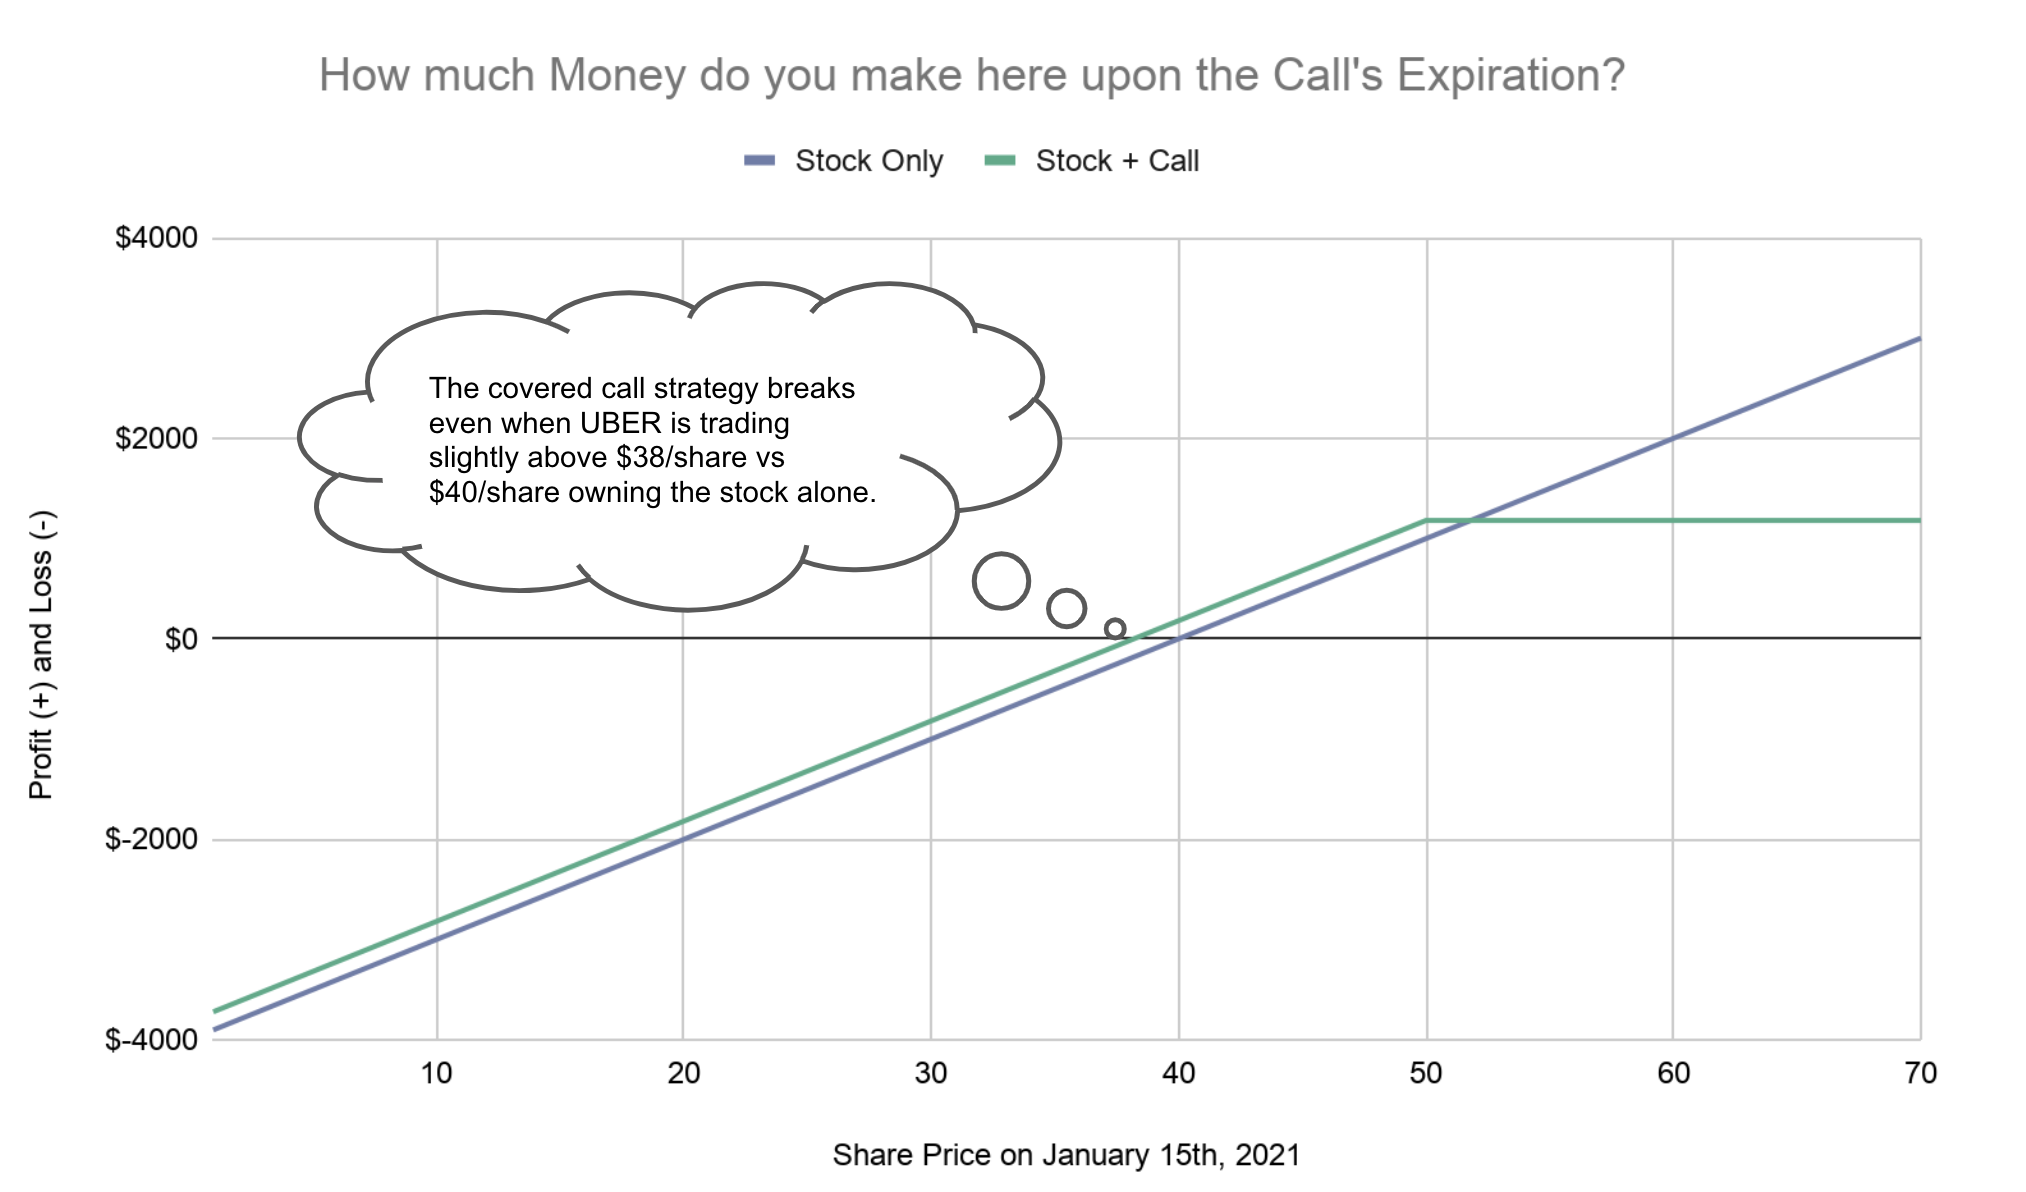

In [52]:
Image('Supplementary Files/Screen Shot 2020-05-20 at 11.52.19 AM.png', height = 100, width= 900)

We can see on the graph that in most cases, you end up making more money through trading the covered call vs owning only stock. Because you're collecting premium to sell the call option, you breakeven on this trade at a lower share price than if you only own stock.

What is your major risk here? The biggest risk is if Uber is trading above \\$50/share on January 15th, 2021 (the expiration date of the call option). Here, the gains you make on your Uber stock are equally offset by losses on the calls you sold. It is important to also note that selling options usually does require that you hold margin in your personal brokerage against the position (as noted in the pair trade section). 

Thus, this trade makes a lot of sense **if you believe that Uber will be trading at or below \\$50/share in January 2021**, a share price which would represent a 20% appreciation from where Uber began trading on its IPO. Full disclosure: I hold a position very similar to this one.

### Conclusion

The goal here was to demonstrate to the broader community how one could go about hedging their startup equity risk through focusing specifically on Uber and Lyft. We identified two ways in which one could hedge this risk: pair trading and covered calls.

This approach can be leveraged across all industries in which publicly tradable assets exist. Are you a DoorDash or CloudKitchens employee concerned about having too much exposure to the food delivery space? If so, you could simply short sell Grubhub shares against your vested equity holdings in the same manner we did with Lyft above. 

If you have any additional questions/comments/concerns, please don't hesitate to email me at adrian@lechterventures.com. Thanks for making it this far; wishing you and your family well! 

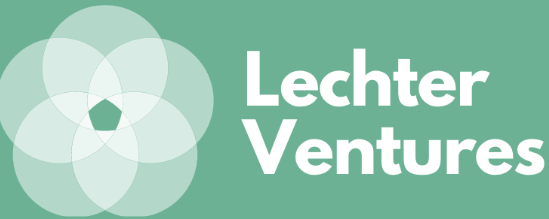

In [53]:
from IPython.display import display, Image
Image('Supplementary Files/Lechter Ventures Master.png')